# IMPLEMETING CIRCUS ALGORITHM
The CIRCUS algorithm is a solver of Linear Programming optimization which uses the idea of circumcenters together with
some techniques applied in the Simplex algorithm. In this notebook, I'll implement the Simplex first, then
implement the **trial version** of the CIRCUS.

In [1]:
using LinearAlgebra
using PyPlot
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


## SIMPLEX
Let's use as example the following case:
$$
\begin{aligned}
\textrm{Maximize} \quad & x_1 + x_2 \\
\textrm{Subject to} \quad &
        -x_1 + x_2  &\leq 1\\
\quad & x_1        &\leq 3\\
\quad & x_2         &\leq 2\\
\quad & x_1,x_2     &\geq 0
\end{aligned}
$$

We then put this in the standard form by adding slack variables:
$$
\begin{aligned}
\textrm{Maximize} \quad & x_1 + x_2 \\
\textrm{Subject to} \quad &
        -x_1 + x_2 + x_3  &= 1\\
\quad & x_1 + x_4        &= 3\\
\quad & x_2 + x_5         &= 2\\
\quad & x_1,x_2,x_3,x_4,x_5     &\geq 0
\end{aligned}
$$

Therefore we have:
$$
\begin{aligned}
\textrm{Maximize} \quad & c^T {x} \\
\textrm{Subject to} \quad & Ax = b \\
\quad & x\geq 0
\end{aligned}
$$

First, we will implement the Simplex Method following the book "Understanding and Using Linear Programming".

In [6]:
A = [-1 1 1 0 0;
      1 0 0 1 0;
      0 1 0 0 1 ]
c = [1,1,0,0,0]
b = [1,3,2]
# starting basic feasible point
xo = [0,0,1,3,2];

function SimplexFromBFS(c,A,b,initial_bfs;max_iterations=100,index_bfs=[0],index_nfs = [0])
    # Initial setup
    e  = 10^-5
    B  = findall(initial_bfs .> 0+e)
    N  = findall(initial_bfs .<= 0+e)
    if size(A[:,B])[1] != size(A[:,B])[2]
        B = index_bfs
        N = index_nfs
    end
    xn = initial_bfs[N]; xb = initial_bfs[B];
    
    # Simplex pivoting iteration
    for i = 1:max_iterations
        Ab = A[:,B]; An = A[:,N]; cb = c[B]; cn = c[N]
        p  = inv(Ab)*b
        Q  = -inv(Ab)*An
        r  = (cb'*Q + cn')'
        if all(r.<= 0)
            x_final = vcat(hcat(B,p),hcat(N,zeros(length(N))))
            x_final = x_final[sortperm(x_final[:,1]),:]
            return x_final
        end
        zo = cb'*p
#         z  = zo + r'*xn
        index_in =findmax(r)[2]
        x_in = N[index_in]
        if any(Q[:,index_in] .< 0)
            coef_entering = -p./Q[:,index_in] 
            q_neg_index   = findall(Q[:,index_in] .< 0)
            index_out     =findfirst(coef_entering .== findmin(coef_entering[q_neg_index])[1])
            x_out     = B[index_out]
            B[index_out] = x_in
            N[index_in]  = x_out
        else
            
            error("Unbounded")
        end
        println(x_in,"   ",x_out)
    end
    x_final = vcat(hcat(B,p),hcat(N,zeros(length(N))))
    x_final = x_final[sortperm(x_final[:,1]),:]
    return x_final
end



SimplexFromBFS (generic function with 1 method)

In [7]:
SimplexFromBFS(c,A,b,xo)

1   4
2   5


5×2 Array{Float64,2}:
 1.0  3.0
 2.0  2.0
 3.0  2.0
 4.0  0.0
 5.0  0.0

### Degenerte example

In [10]:
A = [-1 1 1 0 ;
      1 0 0 1]
c = [0,1,0,0]
b = [0,2]
# starting basic feasible point
xo = [0,0,0,1];
# SimplexFromBFS(c,A,b,xo;max_iterations=10,index_bfs=[3,4],index_nfs=[1,2])
A*xo

2-element Array{Int64,1}:
 0
 1

### CIRCUS 

In [5]:
function CC(S)
    # Function to calculate the circumcenter
    T1 = (S.-S[:,1])[:,2:end]
    T2 = pinv(T1' * T1) # MODIFIED THE ORIGINAL BY THE PSEUDO-INVERSE INSTEAD OF THE INVERSE. IT SEEMS TO WORK... WHY?
    T3 = diag((S.-S[:,1])[:,2:end]' * (S.-S[:,1])[:,2:end])
    cc = S[:,1] + 0.5.*T1 * T2 * T3
    return cc
end

CC (generic function with 1 method)

In [6]:
function CIRCUS(c,Ag,b,initial_point;tolerance=10^-10, max_iterations=100)
    
    norm_row(A,d=2) = sqrt.(sum(abs2,A,dims=d))
    xo = convert(Array{Float64},initial_point)
    xp = [xo]
    
    Ag_normalized = Ag ./ norm_row(Ag)
    c_normalized = c ./ norm(c)
    if sum(Ag*xo .<= b) == size(Ag)[1] #Checking if point is feasible
            println("Initial point feasible")
    else
        println("Initial point not feasible")
        return 0
    end
    
    for i = 1:max_iterations
#         J = findall(Ag*xo - b .== 0) # Active restrictions
        J = findall(abs.(Ag*xo - b .- 0).<tolerance) # Active restrictions
        I = setdiff(1:size(Ag)[1],J) # Inactive restrictions
        angles  = Ag_normalized[J,:]*c_normalized
        J_acute = angles .< 0
        qtd_acute_restrictions = sum(J_acute)
        
        if size(J)[1] == 1
#             println("One restriction and Objective Function")
            S = hcat(-c_normalized,Ag_normalized[J,:]')
            circum = CC(S)
        elseif size(J)[1] == 0
            circum = -c
        elseif size(J)[1] - qtd_acute_restrictions == 0
            circum = CC(Ag_normalized[J,:]')
#             println("Only restrictions circumcentered")
        else
            
            # AJUSTAR ESSA PARTE DO CÓDIGO.
            drop_index = findmin(angles)[2]
            if size(J)[1] == size(Ag)[2]-1
                J_c = J
            else
                J_c = J[1:end .!= drop_index]
            end
            circum = CC(hcat(-c_normalized,Ag_normalized[J_c,:]'))
        end

        eq   = (b[I]-Ag[I,:]*xo) ./ (Ag[I,:]*(-circum))
        eq[eq .< 0] .= Inf
        replace!(eq, NaN=>Inf)
        
        α, J = findmin(eq)
        J    = findall(eq .== α)
        J    = I[J] # new Active restrictions
        I = setdiff(1:size(Ag)[1],J) # new Inactive restrictions
    
        push!(xp,xo-α*circum)
        #Check feasibility
        if sum(Ag*xp[end] .<= b) != size(Ag)[1]
            println("xp not feasible, hence, xo is the optimal solution")
            return xp
        end
        xo = xp[end]
    end
    println("Maximum iteration limit reached.")
    return xp
end

c = [0,0,-1]
A = [-1 1 -1;
     -1 -1 -1;
     1 0 0]
b = [0,0,4]
xo = [0,0,0]
xo = [1,-1,0]
xp = CIRCUS(c,A,b,xo,max_iterations=10)
xp = hcat(xp...)'

px= [0,4 ,4 ,0 ,0,0,0 ,0,4,4,4 ,4]
py= [0,0 ,-4,-4,0,4,-4,4,4,-4,0,4]
pz= [0,-4,0 ,4 ,0,4,4 ,4,0,0,-4,0]
plt= PyPlot.plot3D(px,py,pz)
# PyPlot.scatter3D(px,py,pz)
PyPlot.scatter3D(xp[:,1],xp[:,2],xp[:,3])

PyPlot.scatter3D([xt[1]],[xt[2]],[xt[3]])
PyPlot.plot3D([0,xp[1,1],xt[1]], [0,xp[1,2],xt[2]],[0,xp[1,3],xt[3]])
# PyPlot.plot3D([0,xt[1]], [0,xt[2]],[0,xt[3]])

x1 = rand(100)*(4)
x2 = rand(100)*(-2)
x3 = -x1 - x2
PyPlot.plot3D(x1,x2,x3)

Initial point feasible
xp not feasible, hence, xo is the optimal solution


UndefVarError: UndefVarError: xt not defined

In [8]:
px= [0,4 ,4 ,0 ,0,0,0 ,0,4,4,4 ,4]
py= [0,0 ,-4,-4,0,4,-4,4,4,-4,0,4]
pz= [0,-4,0 ,4 ,0,4,4 ,4,0,0,-4,0]
plt= PyPlot.plot3D(px,py,pz)
PyPlot.scatter3D([x_ref[1]],[x_ref[2]],[x_ref[3]])
PyPlot.plot3D([xo[1],xo[1]+1],[xo[2],xo[2]+1],[xo[3],xo[3]-2])

UndefVarError: UndefVarError: x_ref not defined

### Purification
We will assume the case of no degeneracy first.



In [9]:
function Purification(xo,A,c,J,I)
    xt = xo
    
    Aj    = A[J,:] # Active restriction - use the normalized
    Cproj = c - (Aj.*(Aj * c)./(norm(Aj)^2))'
    eq   = (b[I]-A[I,:]*xt) ./ (A[I,:]*(Cproj))
    eq[eq .< 0] .= Inf
    replace!(eq, NaN=>Inf)

    α, J = findmin(eq)
    J    = findall(eq .== α)
    J    = I[J] # new Active restrictions
    I = setdiff(1:size(A)[1],J) # new Inactive restrictions
    xt = xt+α*Cproj
    
    return xt
    
end

Purification (generic function with 1 method)

In [10]:
J = [2]
I = [1,3]
Purification(xo,A,c,J,I)

3×1 Array{Float64,2}:
  2.0
  0.0
 -2.0

In [11]:
J = [2]
I = [1,3]

Aj    = A[J,:] # Active restriction - use the normalized
Cproj = c - (Aj.*(Aj * c)./(norm(Aj)^2))'
Cnorm = (Aj.*(Aj * c)./(norm(Aj)^2))'
eq   = (b[I]-A[I,:]*xo) ./ (A[I,:]*(Cproj))
eq[eq .< 0] .= Inf
replace!(eq, NaN=>Inf)

α, J = findmin(eq)
xt = xo+α*Cproj
println(Cproj)

J = [2,1]
I = [3]
Aj    = A[J,:] # Active restriction - use the normalized

nj = nullspace(Aj)
Cproj = nj.*(nj'*c)
println(Cproj,xt)

eq   = (b[I]-A[I,:]*xt) ./ (A[I,:]*(Cproj))
eq[eq .< 0] .= Inf
replace!(eq, NaN=>Inf)

α, J = findmin(eq)
xr = xt+α*Cproj

[0.33333333333333337; 0.33333333333333337; -0.6666666666666666]
[0.5; -0.0; -0.4999999999999999][2.0; 0.0; -2.0]


3×1 Array{Float64,2}:
  4.0
  0.0
 -3.9999999999999996

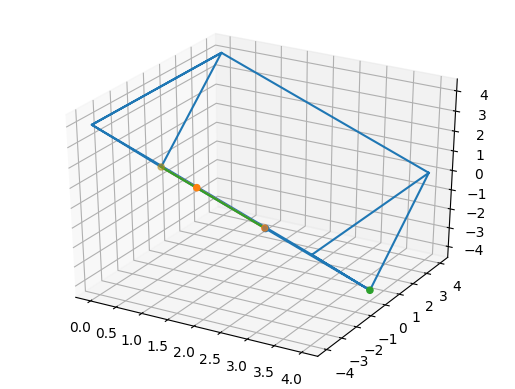

PyObject <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x7fba478a0760>

In [12]:
plt= PyPlot.plot3D(px,py,pz)
PyPlot.scatter3D([xt[1]],[xt[2]],[xt[3]])
PyPlot.plot3D([0,xp[1,1],xt[1]], [0,xp[1,2],xt[2]],[0,xp[1,3],xt[3]])
PyPlot.scatter3D([0,xp[1,1],xt[1]], [0,xp[1,2],xt[2]],[0,xp[1,3],xt[3]])
PyPlot.plot3D([0,xt[1]], [0,xt[2]],[0,xt[3]])
PyPlot.scatter3D([0,xr[1]], [0,xr[2]],[0,xr[3]])